In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d as mv_avg

from aux import Generic
from disp import set_font_size
from ntwk import LIFNtwkI, join_w

cc = np.concatenate

C_M = .2e-9  # F
G_L = 10e-9  # S
TAU_M = C_M/G_L  # s
E_L = -0.05  # V
V_TH = -0.04  # V
V_R = -0.05  # V
T_R = 0.002  # s

DT = 0.0005

Plot output spike probability from $k_{in}$ input spikes w/in 1 $\tau_m$ as func of synaptic weight.

In [2]:
n_trials = 50
k_in = [1, 2, 5, 10, 20]  # total number of input spikes
w = np.linspace(0, .5e-8, 50)  # excitatory weights

p_spks = {k_in_: [] for k_in_ in k_in}
t = DT * np.arange(int(np.round(TAU_M/DT)), dtype=float)
clamp = Generic(v={0: np.array([E_L])}, spk={})
i_ext = np.zeros(len(t))

for k_in_ in k_in:
    p_spk = []
    for w_ in w:
        ntwk = LIFNtwkI(
            c_m=C_M,
            g_l=G_L,
            e_l=E_L,
            v_th=V_TH,
            v_r=V_R,
            t_r=T_R,
            w_r=np.zeros((1, 1)),
            w_u=w_*np.eye(1),
            sparse=False)
        
        spk_out_ctr = 0
        
        for tr_ctr in range(n_trials):
            # make stim
            spks_u = np.zeros((len(t), 1))
            for spk_ctr in range(k_in_):
                spks_u[np.random.randint(0, k_in_), 0] += 1
                
            # drive ntwk
            rslt = ntwk.run(dt=DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)
            
            # count output spks
            spk_out_ctr += int(rslt.spks[:, 0].sum() > 0)
            
        p_spk.append(spk_out_ctr/n_trials)
    p_spks[k_in_] = copy(p_spk)

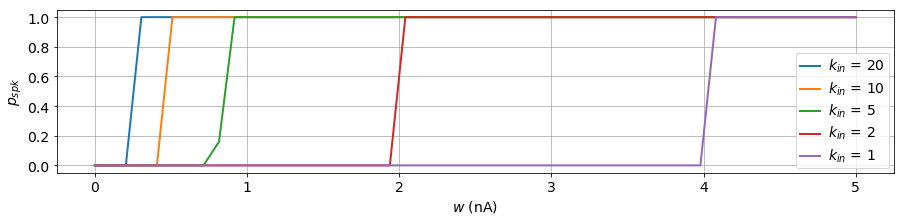

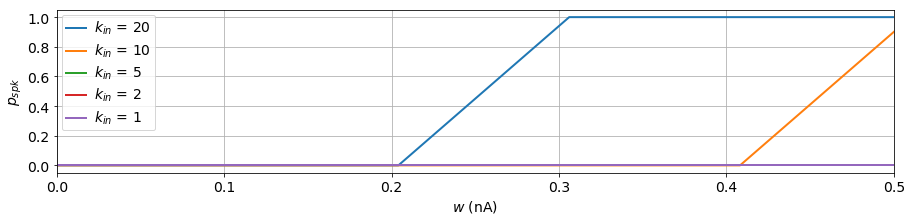

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
for k_in_ in k_in[::-1]:
    ax.plot(1e9 * w, p_spks[k_in_], lw=2)
    
ax.set_xlabel(r'$w$ (nA)')
ax.set_ylabel(r'$p_{spk}$')
ax.legend([r'$k_{in}$ = ' + '{}'.format(k_in_) for k_in_ in k_in[::-1]])

ax.grid()
set_font_size(ax, 14)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
for k_in_ in k_in[::-1]:
    ax.plot(1e9 * w, p_spks[k_in_], lw=2)

ax.set_xlim(0, .5)
ax.set_xlabel(r'$w$ (nA)')
ax.set_ylabel(r'$p_{spk}$')
ax.legend([r'$k_{in}$ = ' + '{}'.format(k_in_) for k_in_ in k_in[::-1]])

ax.grid()
set_font_size(ax, 14)

Demonstrate dependence of population response of balanced E/I ntwk to step current as function of resting potential heterogeneity.

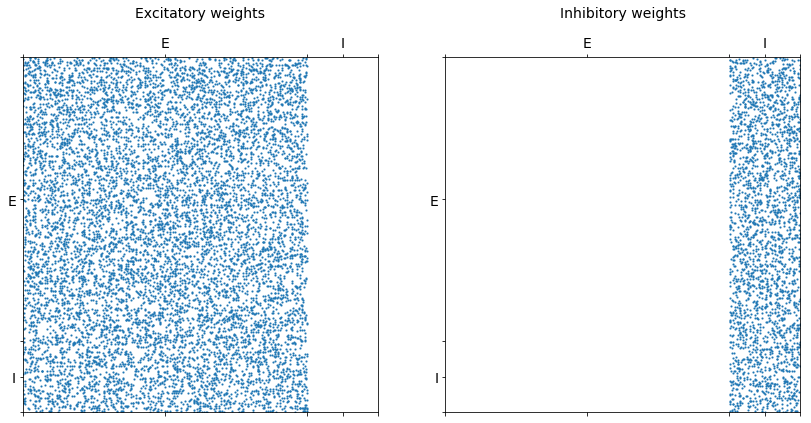

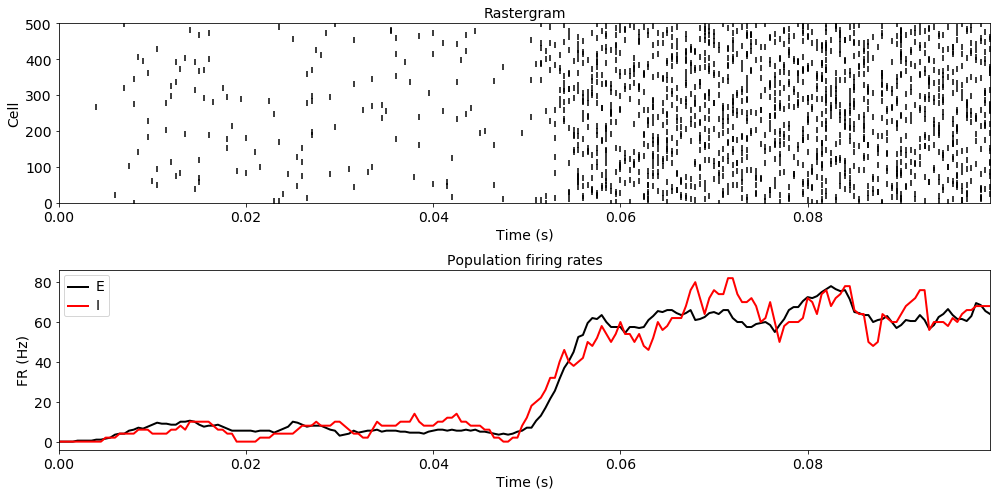

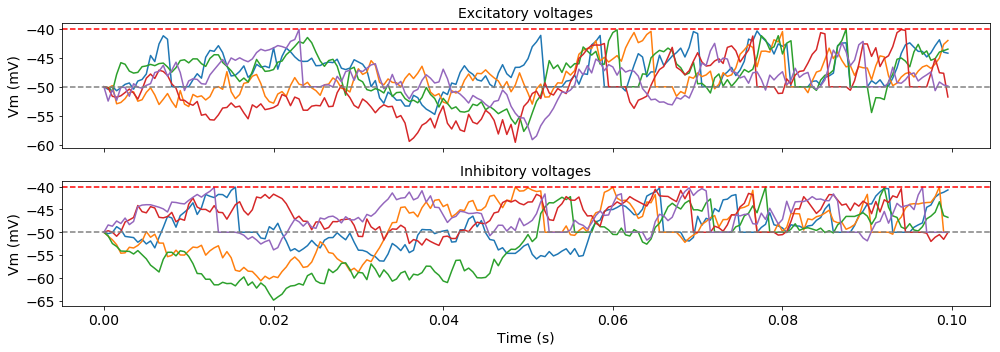

In [4]:
np.random.seed(0)

n_e = 400
n_i = int(n_e/4)
n = n_e + n_i
g = 4

k_e = 20
q = k_e / n_e  # cxn prob

w_ee = .2e-9  # A
w_ie = w_ee
w_ei = -g*w_ee  # I->E cxn weight
w_ii = -g*w_ie  # I->I cxn weight

v_0 = E_L * np.ones(n)

# make weights
## cell types
ct = cc([np.repeat('E', n_e), np.repeat('I', n_i)])

## cell-type specific weights
w_r_indiv = {
    'W': {
        ('E', 'E'): w_ee*(np.random.rand(n_e, n_e) < q),
        ('I', 'E'): w_ie*(np.random.rand(n_i, n_e) < q),
        ('E', 'I'): w_ei*(np.random.rand(n_e, n_i) < q),
        ('I', 'I'): w_ii*(np.random.rand(n_i, n_i) < q),
    },
}

## final w
w_r = join_w(ct, ct, w_r_indiv)['W']

if True:  ## plot sparsity structure
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
    w_r_e = copy(w_r)
    w_r_e[w_r < 0] = 0
    axs[0].spy(w_r_e, markersize=1)
    axs[0].set_title('Excitatory weights\n')
    
    w_r_i = copy(w_r)
    w_r_i[w_r > 0] = 0
    axs[1].spy(w_r_i, markersize=1)
    axs[1].set_title('Inhibitory weights\n')

    for ax in axs:
        ax.set_xticks([-.5, n_e/2 - .5, n_e - .5, .5*(n_e + n) - .5, n - .5])
        ax.set_xticklabels(['', 'E', '', 'I', ''])
        ax.set_yticks([-.5, n_e/2 - .5, n_e - .5, .5*(n_e + n) - .5, n - .5])
        ax.set_yticklabels(['', 'E', '', 'I', ''])

        set_font_size(ax, 14)
        
# make ntwk
ntwk = LIFNtwkI(
    c_m=C_M,
    g_l=G_L,
    e_l=E_L,
    v_th=V_TH,
    v_r=V_R,
    t_r=T_R,
    w_r=w_r,
    w_u=None)

# drive ntwk w step current input
t = np.arange(0, .1, DT)
t_step = .05
i_ext = .5e-9 * np.random.randn(len(t), n)
i_ext[t > t_step] += .2e-9  # A

clamp = Generic(v={0: v_0}, spk={})

# run smln
rslt = ntwk.run(dt=DT, clamp=clamp, i_ext=i_ext)


fig, axs = plt.subplots(2, 1, figsize=(14, 7), tight_layout=True)

# rastergram
axs[0].scatter(rslt.spks_t, rslt.spks_c, c='k', marker='|')
axs[0].set_ylim(-1, n)
axs[0].set_ylabel('Cell')
axs[0].set_title('Rastergram')

# ppln firing rates
wdw_fr_int = int(round(.005/DT))  # smoothing window
fr_e = mv_avg(rslt.spks[:, :n_e].mean(axis=1)/DT, wdw_fr_int)
fr_i = mv_avg(rslt.spks[:, n_e:].mean(axis=1)/DT, wdw_fr_int)
axs[1].plot(t, fr_e, c='k', lw=2)
axs[1].plot(t, fr_i, c='r', lw=2)

axs[1].set_title('Population firing rates')
axs[1].set_ylabel('FR (Hz)')
axs[1].set_xlabel('Time (s)')
axs[1].legend(['E', 'I'])

for ax in axs:
    ax.set_xlim(0, t[-1])
    ax.set_xlabel('Time (s)')
    set_font_size(ax, 14)
    
# example voltages
fig, axs = plt.subplots(2, 1, figsize=(14, 5), sharex=True, tight_layout=True)
axs[0].plot(t, 1000 * rslt.vs[:, :5])
axs[0].set_title('Excitatory voltages')
axs[1].plot(t, 1000 * rslt.vs[:, n_e:n_e+5])
axs[1].set_title('Inhibitory voltages')
axs[1].set_xlabel('Time (s)')

for ax in axs:
    ax.axhline(1000 * E_L, color='gray', ls='--')
    ax.axhline(1000 * V_TH, color='red', ls='--')
    ax.set_ylabel('Vm (mV)')
    
    set_font_size(ax, 14)